# DCASE Dev datasets: small stats

In [1]:
import pandas as pd
import os
import soundfile as sf
import matplotlib.pyplot as plt
import glob
%matplotlib inline

Paths to the annotations

In [2]:
datasets = ['Training_Set', 'Validation_Set']
path_annot = '/home/postdoc/PaulNHD//Development_Set'

Load all annotations into a single dataframe by iterating over the subfolders. Add 'label'&'duration' columns 

In [3]:
df_all = pd.DataFrame()
cols_to_keep = ['Audiofilename', 'Starttime', 'Endtime', 'label', 'sr', 'audiofile_duration', 'nb_channels', 'dataset']
for dataset in datasets:
    df_list = []
    for ind, annot_file in enumerate(glob.glob(os.path.join(path_annot, dataset, '**/*.csv'))):
        # Extract info from the audio data
        audio_info = sf.info(annot_file.replace('.csv', '.wav'))
        # Read the CSV file
        df_file = pd.read_csv(annot_file)
        # Keep only POS row
        df_file = df_file[df_file.eq('POS').any(1)]
        # Add a label column containing only the row with one label. Might have issues if in the annotations there
        # are overlapping calls
        if 'Validation_Set' == dataset:
            df_file['label'] = 'Species_' + str(ind)
        else:
            df_file['label'] = df_file.apply(lambda x: x.index[x == 'POS'][0], axis=1)
        df_file['sr'] = audio_info.samplerate
        df_file['audiofile_duration'] = audio_info.duration
        df_file['nb_channels'] = audio_info.channels
        df_file['dataset'] = dataset
        # Remove other columns and keep the label column only
        df_file = df_file[cols_to_keep]
        # Add the df to the list of df
        df_list.append(df_file)
    # Concatenate all dataframes
    df_all = pd.concat([df_all] + df_list) if ~df_all.empty else pd.concat(df_all)
    # Compute durations for all calls
    df_all['call_duration'] = df_all['Endtime'] - df_all['Starttime']

In [4]:
# Print the different sampling rates used in the dataset
print("Sampling rates : {sampling_rates}".format(sampling_rates=df_all.sr.unique()))
print("-------------")

print("Nb channels : {channels}".format(channels=df_all.nb_channels.unique()))
print("-------------")

Sampling rates : [ 8000 22050 24000 44100 48000 32000  6000]
-------------
Nb channels : [1 2]
-------------


Extract some stats for each 'label'

-------------
Training_Set
-------------
Specie : AGGM
-------------
Nb of extracted samples : 53
-------------
Duration stats count    53.000000
mean      0.414113
std       0.247923
min       0.000000
25%       0.232000
50%       0.397000
75%       0.536000
max       1.265000
Name: call_duration, dtype: float64
-------------


Specie : AMRE
-------------
Nb of extracted samples : 42
-------------
Duration stats count    4.200000e+01
mean     1.500000e-01
std      3.943626e-13
min      1.500000e-01
25%      1.500000e-01
50%      1.500000e-01
75%      1.500000e-01
max      1.500000e-01
Name: call_duration, dtype: float64
-------------


Specie : BBWA
-------------
Nb of extracted samples : 29
-------------
Duration stats count    2.900000e+01
mean     1.500000e-01
std      2.843282e-13
min      1.500000e-01
25%      1.500000e-01
50%      1.500000e-01
75%      1.500000e-01
max      1.500000e-01
Name: call_duration, dtype: float64
-------------


Specie : BTBW
-------------
Nb of extract

-------------
Validation_Set
-------------
Specie : Species_0
-------------
Nb of extracted samples : 52
-------------
Duration stats count    52.000000
mean      0.021941
std       0.014965
min       0.007739
25%       0.012632
50%       0.016909
75%       0.026818
max       0.088152
Name: call_duration, dtype: float64
-------------


Specie : Species_1
-------------
Nb of extracted samples : 22
-------------
Duration stats count    22.000000
mean      0.196705
std       0.079892
min       0.092889
25%       0.151375
50%       0.171274
75%       0.210396
max       0.402681
Name: call_duration, dtype: float64
-------------


Specie : Species_10
-------------
Nb of extracted samples : 104
-------------
Duration stats count    104.000000
mean       8.648725
std        4.387314
min        2.431136
25%        5.289362
50%        7.667932
75%       11.751582
max       23.483451
Name: call_duration, dtype: float64
-------------


Specie : Species_11
-------------
Nb of extracted samples : 24

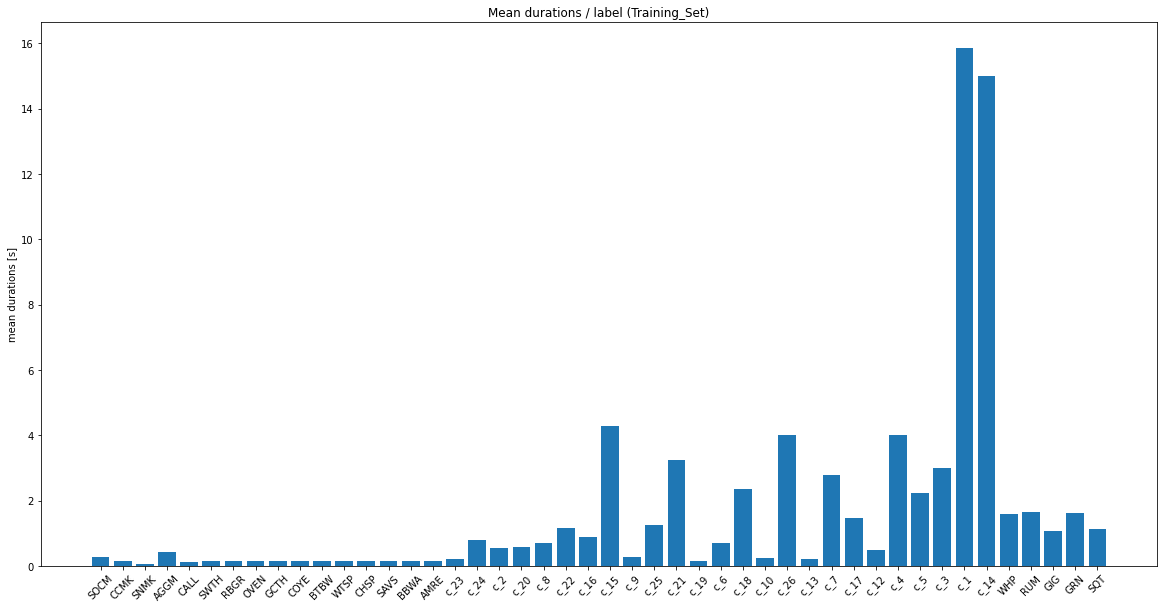

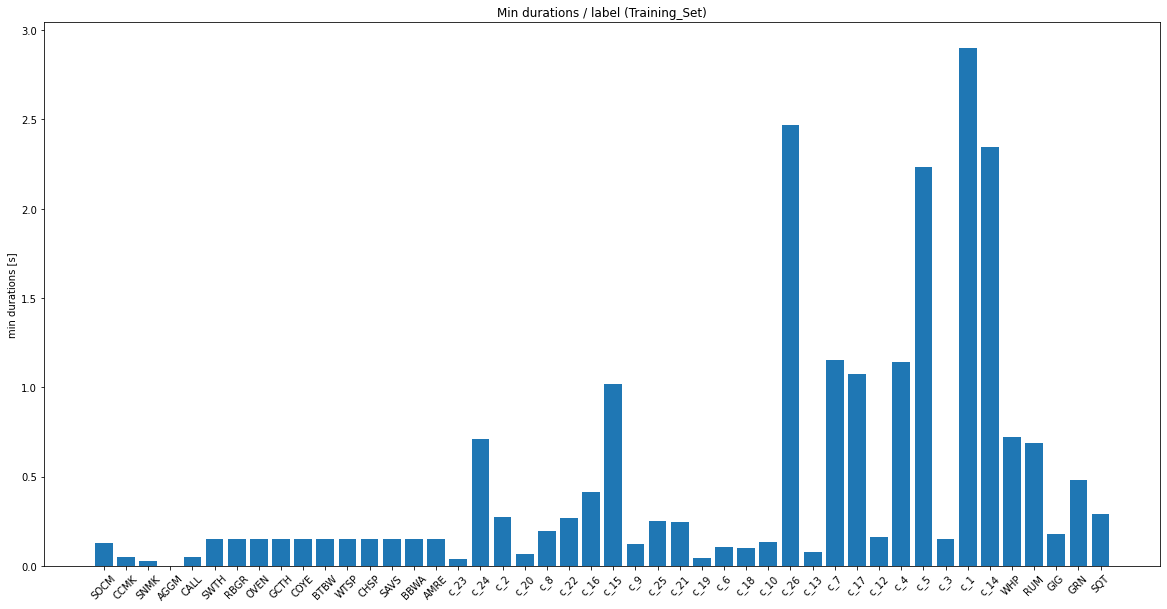

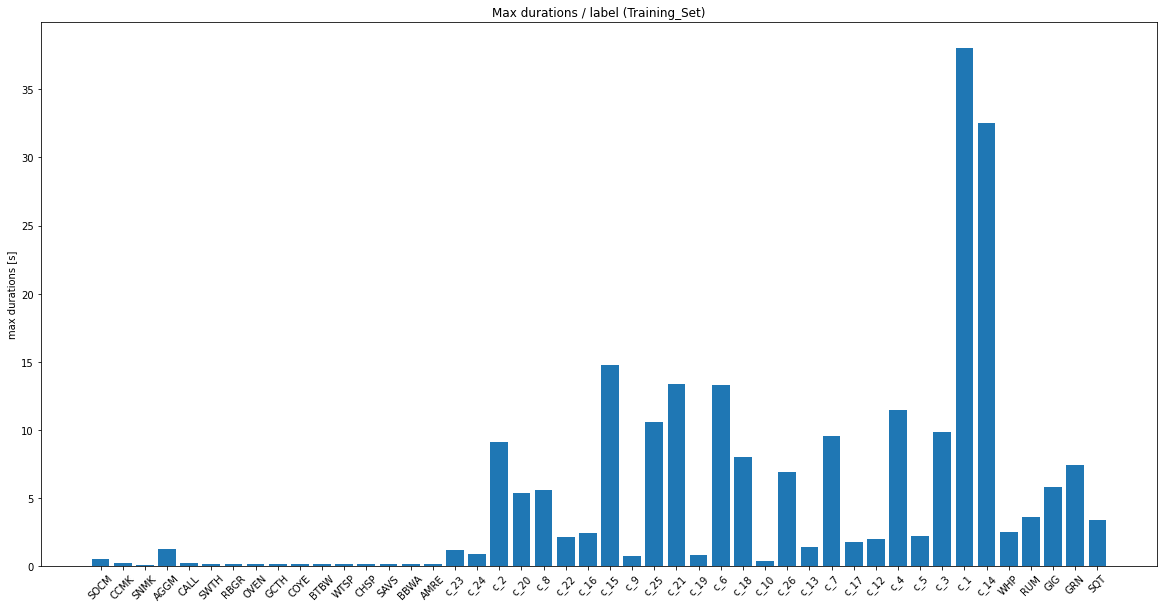

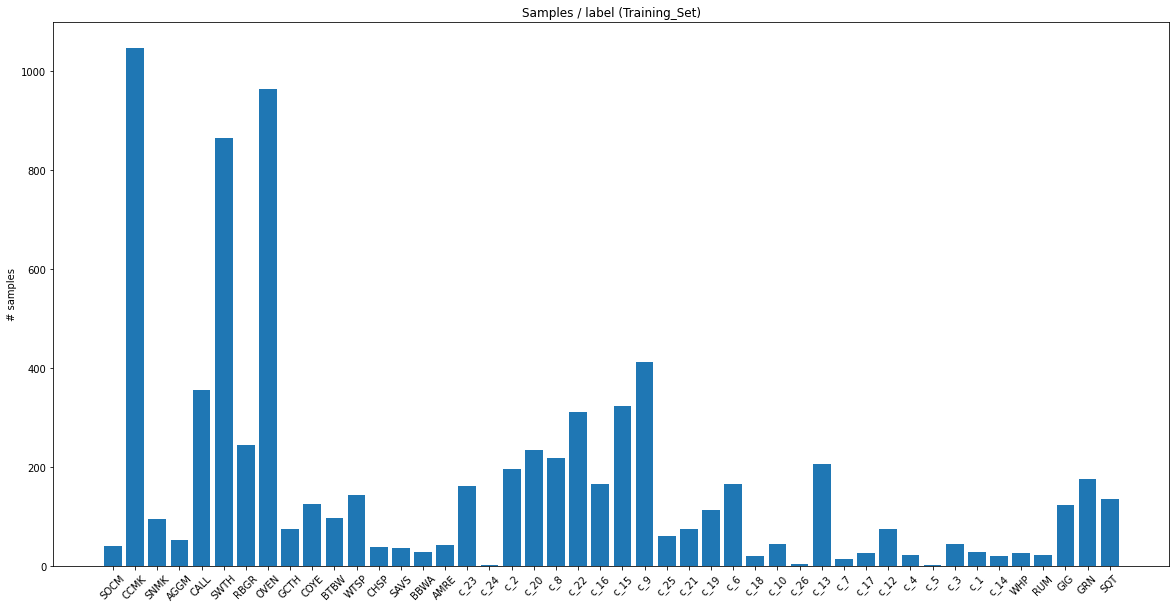

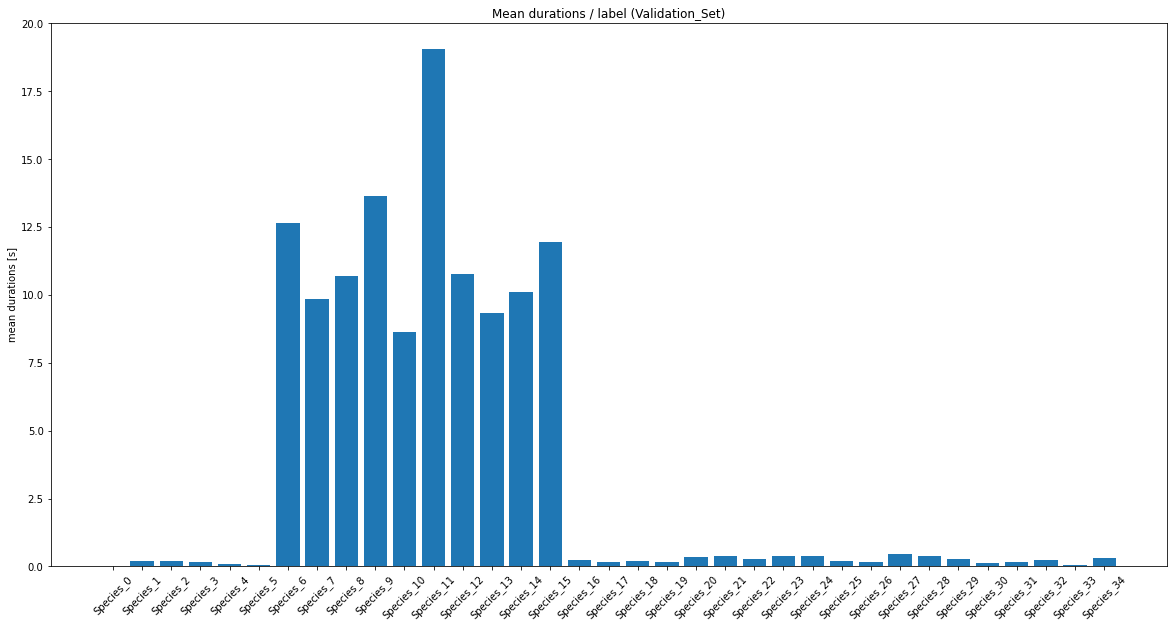

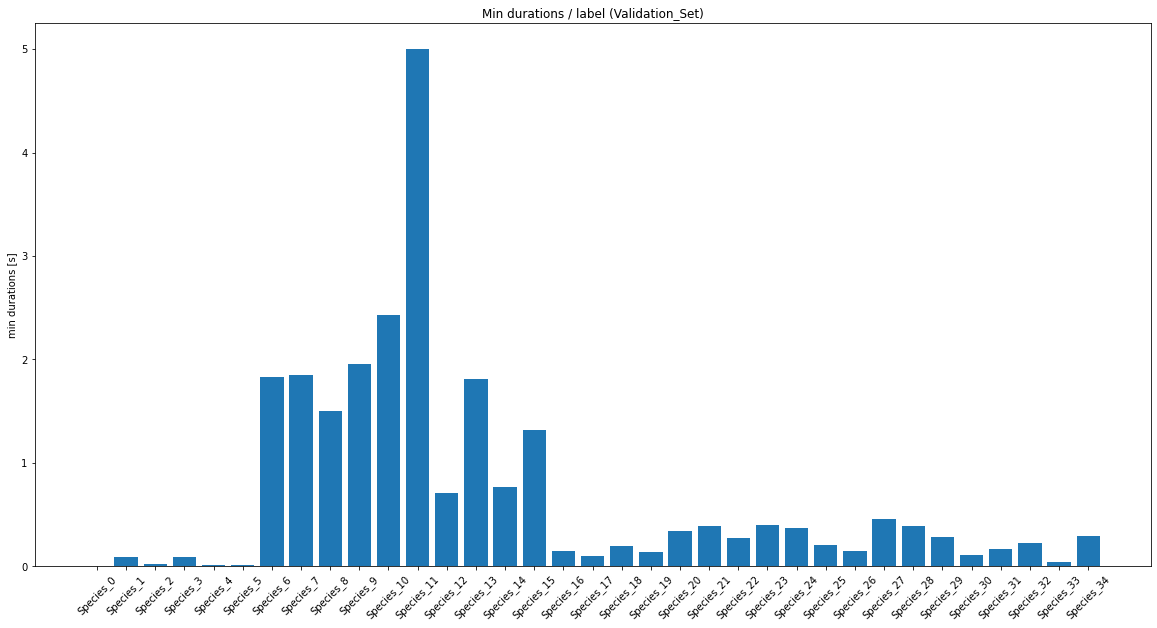

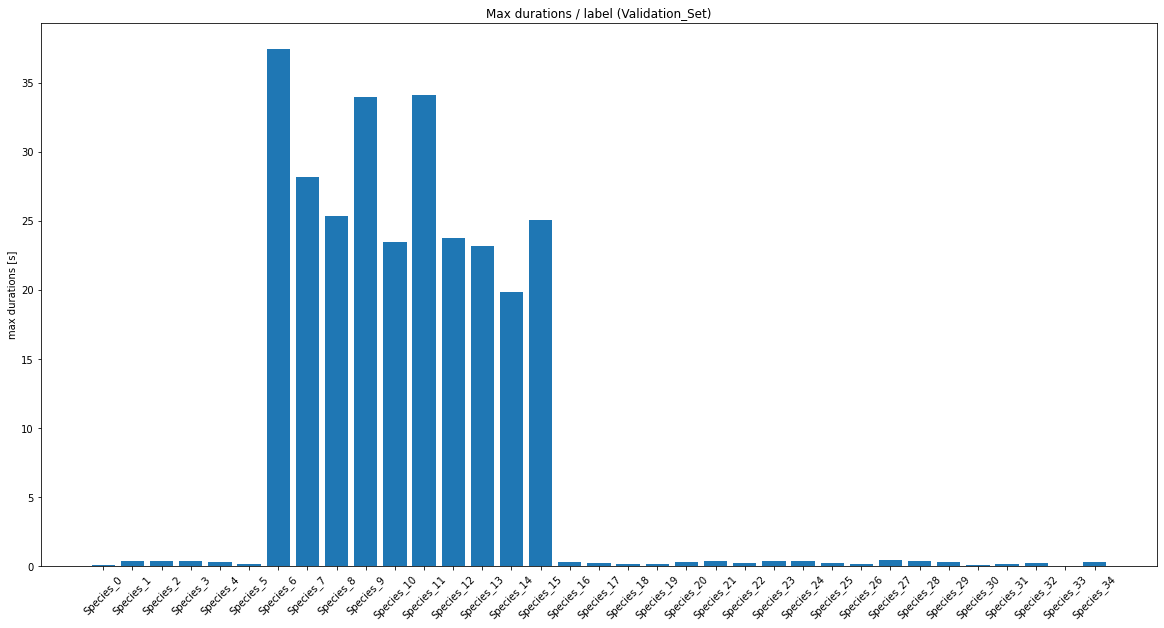

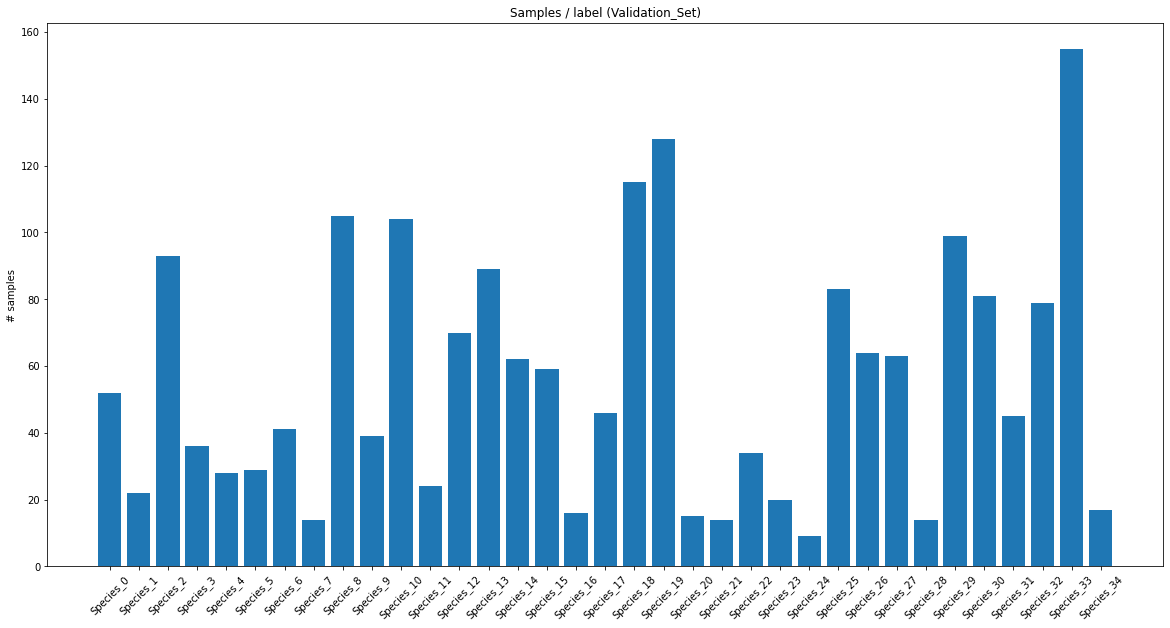

In [5]:
for dataset_name, dataset_df in df_all.groupby('dataset'):
    print("-------------")
    print("{ds}".format(ds=dataset_name))
    print("-------------")
    dict_means = {call_type: 0. for call_type in dataset_df.label.unique()}
    dict_mins = {call_type: 0. for call_type in dataset_df.label.unique()}
    dict_maxs = {call_type: 0. for call_type in dataset_df.label.unique()}
    dict_samples = {call_type: 0. for call_type in dataset_df.label.unique()}
    # Group by call types
    call_type_groups = dataset_df.groupby('label')

    for call_type, group in call_type_groups:
        print("Specie : {specie}".format(specie=call_type))
        print("-------------")
        print("Nb of extracted samples : {nb_samples}".format(nb_samples=len(group)))
        print("-------------")
        print("Duration stats", group.call_duration.describe())
        print("-------------\n\n")
        dict_means[call_type] = group.call_duration.mean()
        dict_mins[call_type] = group.call_duration.min()
        dict_maxs[call_type] = group.call_duration.max()
        dict_samples[call_type] = len(group)

    plt.figure(figsize=(20, 10))
    plt.bar(*zip(*dict_means.items()))
    plt.xticks(rotation=45)
    plt.ylabel('mean durations [s]')
    plt.title('Mean durations / label ({ds})'.format(ds=dataset_name))
    plt.figure(figsize=(20, 10))
    plt.bar(*zip(*dict_mins.items()))
    plt.xticks(rotation=45)
    plt.title('Min durations / label ({ds})'.format(ds=dataset_name))
    plt.ylabel('min durations [s]')
    plt.figure(figsize=(20, 10))
    plt.bar(*zip(*dict_maxs.items()))
    plt.xticks(rotation=45)
    plt.title('Max durations / label ({ds})'.format(ds=dataset_name))
    plt.ylabel('max durations [s]')
    plt.figure(figsize=(20, 10))
    plt.bar(*zip(*dict_samples.items()))
    plt.xticks(rotation=45)
    plt.title('Samples / label ({ds})'.format(ds=dataset_name))
    plt.ylabel('# samples')


Plots

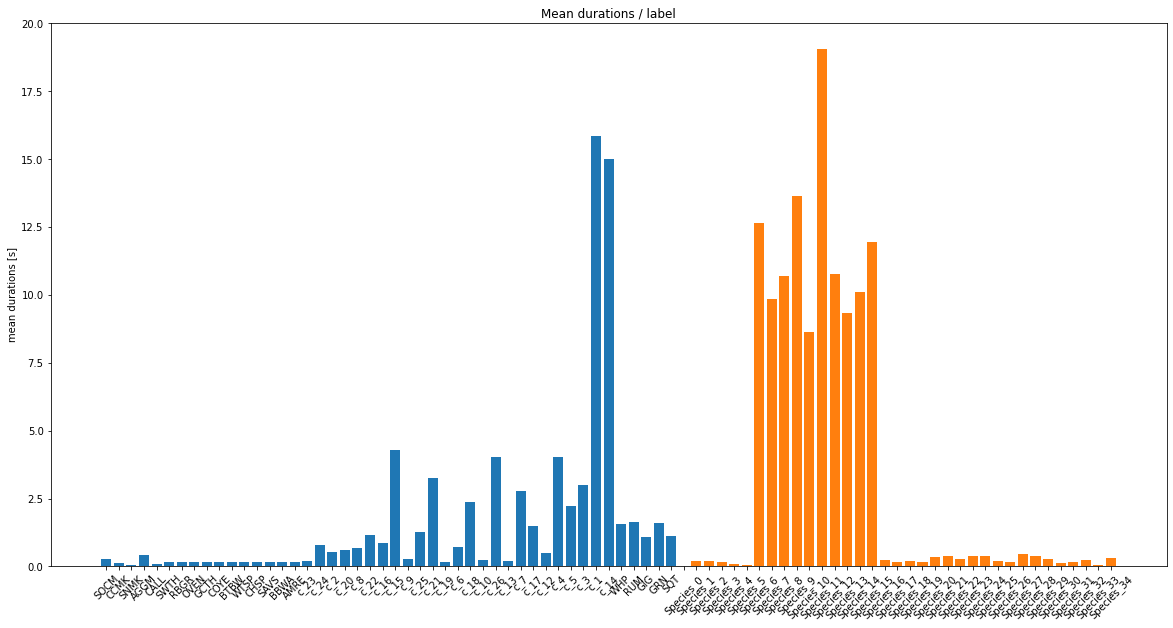

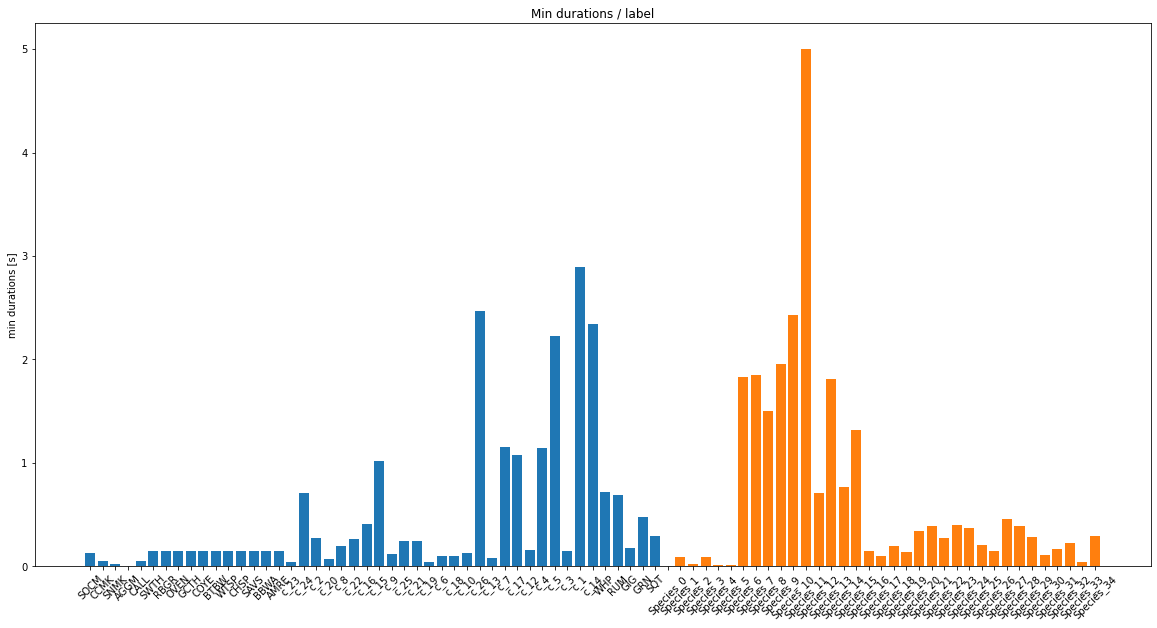

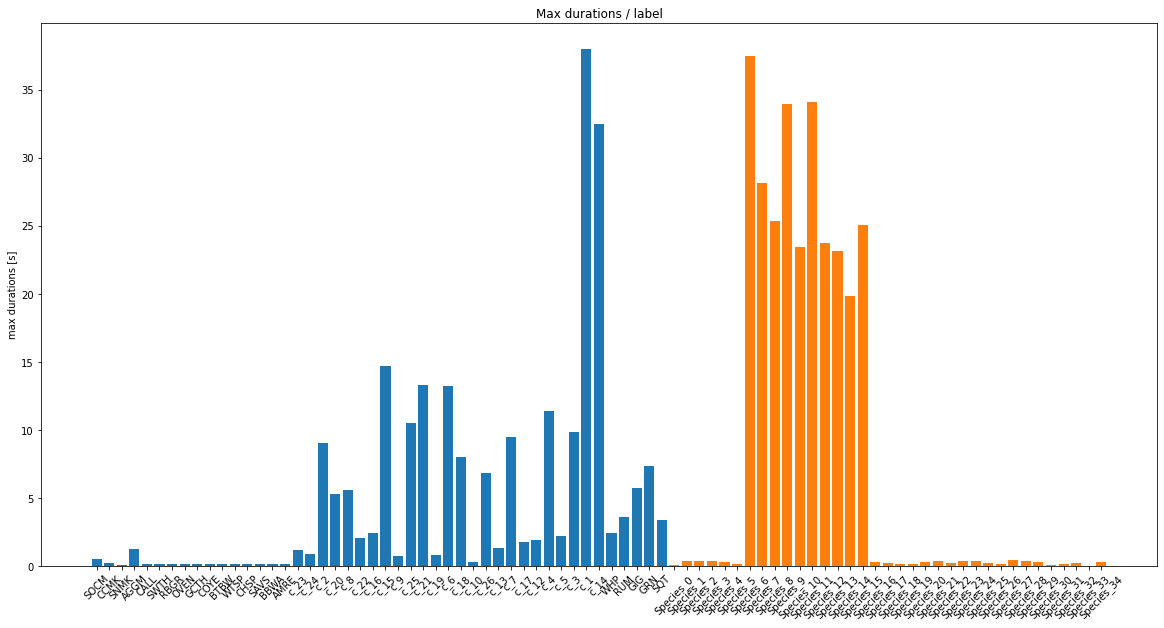

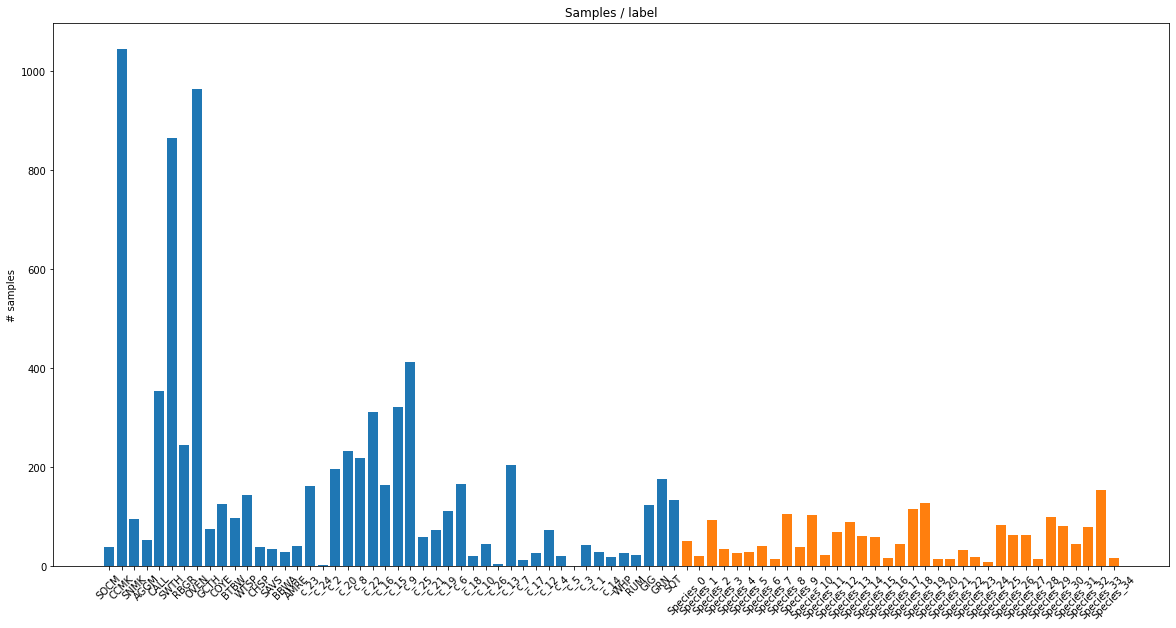

In [6]:
for dataset_name, dataset_df in df_all.groupby('dataset'):
    dict_means = {call_type: 0. for call_type in dataset_df.label.unique()}
    dict_mins = {call_type: 0. for call_type in dataset_df.label.unique()}
    dict_maxs = {call_type: 0. for call_type in dataset_df.label.unique()}
    dict_samples = {call_type: 0. for call_type in dataset_df.label.unique()}
    # Group by call types
    call_type_groups = dataset_df.groupby('label')

    for call_type, group in call_type_groups:
        dict_means[call_type] = group.call_duration.mean()
        dict_mins[call_type] = group.call_duration.min()
        dict_maxs[call_type] = group.call_duration.max()
        dict_samples[call_type] = len(group)

    plt.figure('Means', figsize=(20, 10))
    plt.bar(*zip(*dict_means.items()))
    plt.xticks(rotation=45)
    plt.ylabel('mean durations [s]')
    plt.title('Mean durations / label')
    plt.figure('Mins', figsize=(20, 10))
    plt.bar(*zip(*dict_mins.items()))
    plt.xticks(rotation=45)
    plt.title('Min durations / label')
    plt.ylabel('min durations [s]')
    plt.figure('Maxs', figsize=(20, 10))
    plt.bar(*zip(*dict_maxs.items()))
    plt.xticks(rotation=45)
    plt.title('Max durations / label')
    plt.ylabel('max durations [s]')
    plt.figure('Samples', figsize=(20, 10))
    plt.bar(*zip(*dict_samples.items()))
    plt.xticks(rotation=45)
    plt.title('Samples / label')
    plt.ylabel('# samples')

Check max durations

In [7]:
for dataset_name, dataset_df in df_all.groupby('dataset'):
    print("-------------")
    print("{ds}".format(ds=dataset_name))
    print("-------------")
    print("Max call duration")
    print("-------------")
    print(dataset_df[dataset_df['call_duration'] == dataset_df['call_duration'].max()])
    print("-------------")
    print("Min call duration")
    print("-------------")
    print(dataset_df[dataset_df['call_duration'] == dataset_df['call_duration'].min()])
    print('\n\n')

-------------
Training_Set
-------------
Max call duration
-------------
  Audiofilename  Starttime   Endtime label     sr  audiofile_duration  \
3  XC416749.wav  50.588369  88.61592   c_1  44100          241.554286   

   nb_channels       dataset  call_duration  
3            2  Training_Set      38.027551  
-------------
Min call duration
-------------
     Audiofilename  Starttime   Endtime label    sr  audiofile_duration  \
191  dcase_MK1.csv   1042.835  1042.835  AGGM  8000          1920.91925   

     nb_channels       dataset  call_duration  
191            1  Training_Set            0.0  



-------------
Validation_Set
-------------
Max call duration
-------------
                        Audiofilename   Starttime     Endtime      label  \
27  R4_cleaned recording_17-10-17.wav  398.267936  435.735486  Species_6   

       sr  audiofile_duration  nb_channels         dataset  call_duration  
27  44100          656.083741            1  Validation_Set       37.46755  
------------

# Notes

## Data cleaning

- Different sampling rates, nb of channels
- Big range of durations (check the longest ones, they are super funny!). Some calls with duration = 0 to remove

## Next

- Wide range of calls tonals, harmonics, short/big freq bandwidth -> Display some calls just to see how they look (TF, waveforms, ... representations)